# Learning Outcomes

##### Built a Data Pipeline
##### Preprocessed Images for Deep Learning
##### Created a Deep Neural Network Classifier
##### Evaluated Model Performance
##### Saved Model for Deployment

### Step 1 - Install Dependencies

In [1]:
#pip list 

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import os
import cv2 as cv
import imghdr #checking file extension of the images 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

### Step 2 - Cleaning Dataset

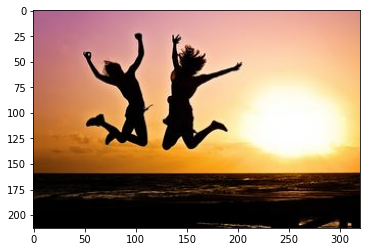

In [4]:
sample = cv.imread('/Users/macbookpro/Desktop/Keras/data/happy/hap.jpg')
plt.imshow(cv.cvtColor(sample, cv.COLOR_BGR2RGB))
plt.show()

In [5]:
data_dir = 'data'

In [6]:
#os.listdir(os.path.join(data_dir, 'happy'))
os.listdir(data_dir)

['happy', 'sad']

In [7]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']  #created a list of image extensions needed

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv.imread(image_path)
            check = imghdr.what(image_path)
            if check not in image_exts:
                print("E no follow".format(image_path))
                os.remove(image_path)
        except Exception as e: 
                print('Issue with Image'.format(image_path))
        

Issue with Image


### Step 3 - Load Data

#### Building Data Pipeline

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 169 files belonging to 2 classes.


2023-01-04 20:41:17.669361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#reconfigure the images to your spec tf.keras.utils.image_dataset_from_directory('data', batch_size=8, image_size=(128,128))  

#### Accessing the Data Pipeline

In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
#Creates new batch of images 

batch = data_iterator.next()

In [13]:
batch[0].shape      #configured image shape

(32, 256, 256, 3)

In [14]:
batch[1]

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int32)

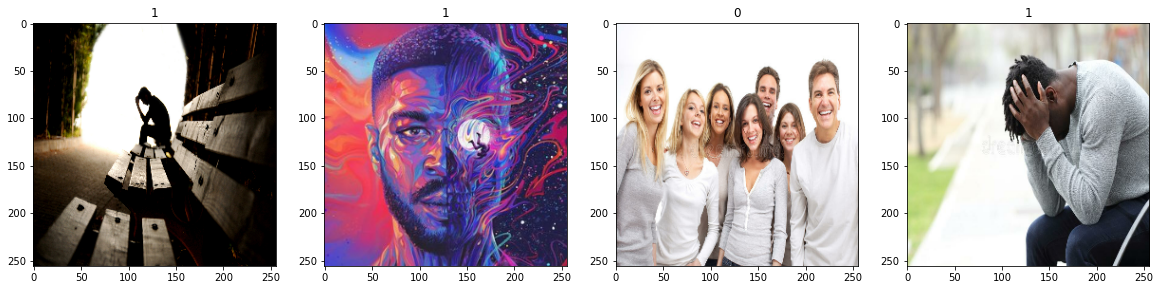

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
#Zero - Happy Images
#One - Sad Images

### Step 4 - Scaling Dataset

In [16]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
batch[0].min()

0.0

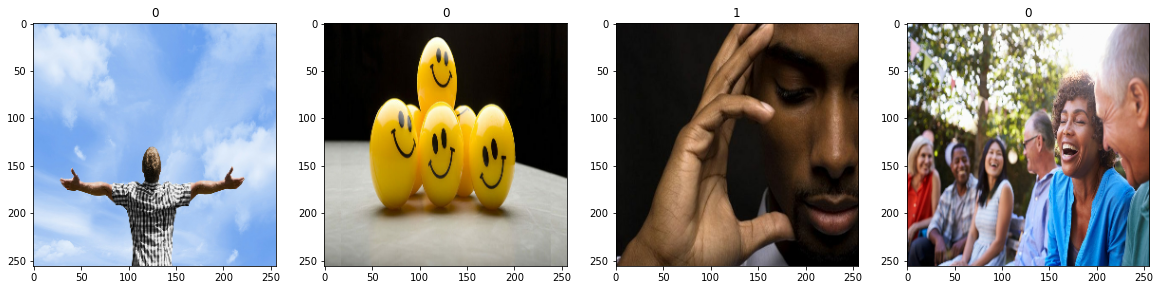

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Step 5 - Split Data

In [21]:
len(data)

6

In [22]:
train_size = int(len(data)*0.70)
validation_size = int(len(data)*0.20)
test_size = int(len(data)*0.10)+1

In [23]:
train_size, validation_size, test_size


(4, 1, 1)

In [24]:
train_data = data.take(train_size)
validation_data = data.skip(train_size).take(validation_size)
test_data = data.skip(train_size+validation_size).take(test_size)

In [25]:
len(train_data), len(validation_data), len(test_data)

(4, 1, 1)

### Step 6 - Deep Learning Model

#### Build Model

In [26]:
model = Sequential()

In [27]:
#Layer 1
model.add(Conv2D(16, #filter 
                 (3,3), #filtersize
                 1, #strides
                 activation = 'relu',
                 input_shape = (256,256,3)))
model.add(MaxPooling2D())

#Layer 2
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#Layer 3
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

#Layer 4
model.add(Dense(256, activation='relu'))

#Output Layer
model.add(Dense(1, activation='sigmoid'))

#### Compile Model

In [28]:
model.compile('adam', #optimizer
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### Fit Model

In [30]:
logdir = 'logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) 

#logs all our model info to tensorboard for easy access to our model info from tensorboard

In [32]:
model_fit = model.fit(train_data, epochs=20, validation_data=validation_data, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 1.1143 - accuracy: 0.5000 - val_loss: 0.7844 - val_accuracy: 0.5312
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.8026 - accuracy: 0.5781 - val_loss: 0.8106 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.6530 - accuracy: 0.5703 - val_loss: 0.6326 - val_accuracy: 0.7812
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.6096 - accuracy: 0.8203 - val_loss: 0.5914 - val_accuracy: 0.6562
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.5523 - accuracy: 0.6797 - val_loss: 0.4799 - val_accuracy: 0.9062
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 0.4881 - accuracy: 0.8594 - val_loss: 0.4490 - val_accuracy: 0.8750
Epoch 7/20
4/4 [==============================] - 5s 1s/step - loss: 0.4090 - accuracy: 0.8359 - val_loss: 0.3823 - val_accuracy: 0.8438
Epoch 8/20
4/4 [=========================

#### Visualize Model Performance

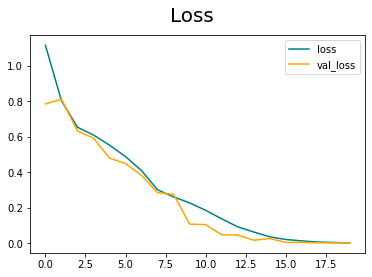

In [33]:
fig=plt.figure()
plt.plot(model_fit.history['loss'], color='teal', label='loss')
plt.plot(model_fit.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

<font color=blue>**From the plot above, we see that the validation loss and loss values reduces, which is good.**</font>

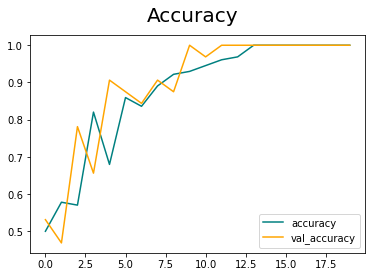

In [34]:
fig=plt.figure()
plt.plot(model_fit.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_fit.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='lower right')
plt.show()

<font color=blue>**From the plot above, we see that the accuracy and val_accuracy increases, which is Super!.**</font>

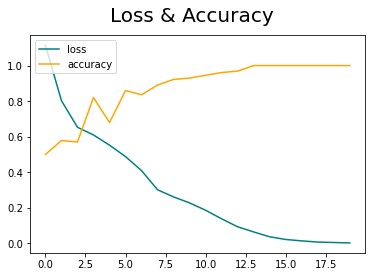

In [35]:
fig=plt.figure()
plt.plot(model_fit.history['loss'], color='teal', label='loss')
plt.plot(model_fit.history['accuracy'], color='orange', label='accuracy')
fig.suptitle('Loss & Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

<font color=blue>**The accuracy of our model increases as the losses drops.**</font>

### Step 7 - Evaluate Model

In [48]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [51]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 68ms/step


In [55]:
print(f'Precision:{precision.result()}, Recall:{recall.result()}, Accuracy:{accuracy.result()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


### Step 8 - Test Model

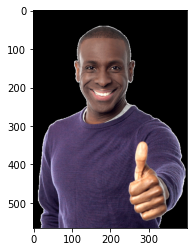

In [60]:
test = cv.imread('/Users/macbookpro/Desktop/Keras/happytest.jpg')
plt.imshow(cv.cvtColor(test, cv.COLOR_BGR2RGB))
plt.show()

<font color=blue>**Image has to be resized to suit the model specifications of 256.**</font>

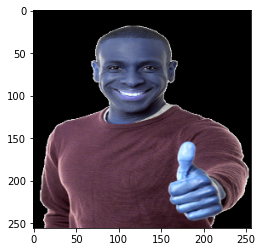

In [68]:
resized = tf.image.resize(test, (256,256))
plt.imshow(resized.numpy().astype(int))
plt.show()

#### Testing

In [69]:
yhat = model.predict(np.expand_dims(resized/255,0))

1/1 [==============================] - 0s 69ms/step


In [70]:
yhat

array([[0.00187694]], dtype=float32)

<font color=blue>**Model has predicted accurately with a result of 0.0019 showing that the image is a happy person.**</font>

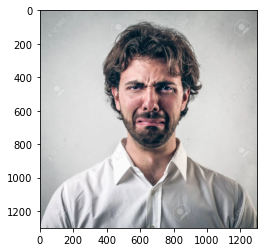

In [78]:
test = cv.imread('/Users/macbookpro/Desktop/Keras/sadtest.jpg')
plt.imshow(cv.cvtColor(test, cv.COLOR_BGR2RGB))
plt.show()

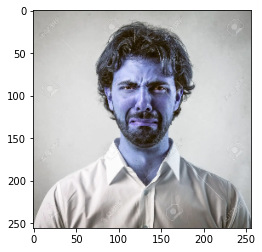

In [79]:
resized = tf.image.resize(test, (256,256))
plt.imshow(resized.numpy().astype(int))
plt.show()

In [82]:
yhat = model.predict(np.expand_dims(resized/255,0))

1/1 [==============================] - 0s 28ms/step


In [83]:
yhat

array([[0.9697515]], dtype=float32)

In [86]:
if yhat >= 0.5:
    print('The image is a sad person')
else:
    print('The image is a happy person')

The image is a sad person


### Step 9 - Save Model

In [88]:
model.save(os.path.join('model', 'imageclassifier.h5'))

In [89]:
reloaded_model = load_model(os.path.join('model', 'imageclassifier.h5'))

In [90]:
reloaded_model

#### END END END